# Zonal Statistics with ASTER and GOES-16 ABI Thermal Infrared Radiance Imagery

In [1]:
# xarray family of packages for working with raster data
import xarray as xr
import xrspatial as xrs
import rioxarray

# aster_utils for unit conversion from AST_L1T digital number to radiance
import aster_utils 

# our favorite python packages for arrays, data frames, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


---
**Open and clean-up input datasets**

Use rioxarray to open a GeoTIFF of GOES-16 ABI Radiance that has been orthorectified for our study area

In [2]:
goes_rad_filepath = '/storage/GOES/orthorectified/2017/04/21/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M4C14_G16_s20171111845222_e20171111850023_c20171111850035_orthorectified_Rad.tif'
goes_rad = xr.open_rasterio(goes_rad_filepath)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/backends/rasterio_.py:260: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  x, _ = (np.arange(nx) + 0.5, np.zeros(nx) + 0.5) * riods.transform
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/backends/rasterio_.py:261: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  _, y = (np.zeros(ny) + 0.5, np.arange(ny) + 0.5) * riods.transform


Open its associated GOES "zone_labels" GeoTIFF raster that was generated at the same time the image was orthorectified

In [3]:
goes_zones_filepath = '/storage/GOES/orthorectified/2017/04/21/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M4C14_G16_s20171111845222_e20171111850023_c20171111850035_orthorectified_zone_labels.tif'
goes_zones = xr.open_rasterio(goes_zones_filepath)

Open the coincident ASTER thermal infrared radiance GeoTIFF image we want to compare with

In [4]:
aster_rad_filepath = '/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'
aster_src = xr.open_rasterio(aster_rad_filepath)

Define a working area her in local UTM coordinates to clip all three rasters to the same common area

In [5]:
utm_northings_max = 4205000
utm_northings_min = 4185000
utm_eastings_max = 305000
utm_eastings_min = 285000

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]

Use reproject_match to align the GOES radiance and GOES zones rasters to the ASTER image, clip to the geometry defined above, and set zone values to integers.

In [6]:
# Reproject match goes rad raster to aster, clip to geometry,  and squeeze out extra dim
goes_rad_repr = goes_rad.rio.reproject_match(aster_src).rio.clip(geometries).squeeze().rename('goes')
# convert GOES radiance (mW m^-2 sr^-1 1/cm^-1) to match MODIS and ASTER (W m^-2 sr^-1 um^-1)
goes_rad_repr = (goes_rad_repr / 1000) * (61.5342/0.7711)
# Reproject match goes zones raster to aster, clip to geometry, set datatype to integer, and squeeze out extra dim
goes_zones_repr = goes_zones.rio.reproject_match(aster_src).rio.clip(geometries).astype('int').squeeze().rename('zones')

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


Clean up the ASTER image by replacing nodata values with NaN, removing an extra dimension, converting the digital number values to radiance values, and finally clipping to the geometry defined above.

In [7]:
# Replace the nodatavals with NaN, squeeze out the band dim we don't need
aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan).squeeze()
# Convert ASTER DN to Radiance
aster_band = 14
aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
# set crs back
aster_rad.rio.set_crs(aster_src.crs, inplace=True)
# clip to geometry
aster_rad_clipped = aster_rad.rio.clip(geometries).rename('aster')

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


Plot each of these images:

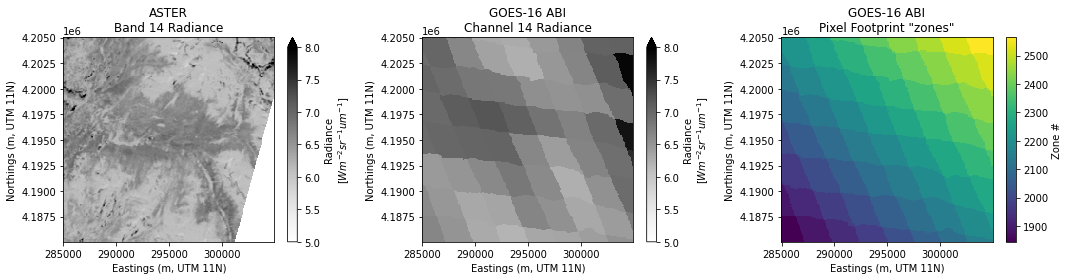

In [8]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3, figsize=(15,4), tight_layout=True)

aster_rad_clipped.plot(ax=ax1, cmap='Greys', vmin=5, vmax=8, cbar_kwargs={'label': 'Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]'})
ax1.set_title('ASTER\nBand 14 Radiance')

goes_rad_repr.plot(ax=ax2, cmap='Greys', vmin=5, vmax=8, cbar_kwargs={'label': 'Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]'})
ax2.set_title('GOES-16 ABI\nChannel 14 Radiance')

goes_zones_repr.plot(ax=ax3, cbar_kwargs={'label': 'Zone #'})
ax3.set_title('GOES-16 ABI\nPixel Footprint "zones"')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylabel('Northings (m, UTM 11N)')
    this_ax.set_xlabel('Eastings (m, UTM 11N)')

---
**Compute zonal statistics and format results**

Compute zonal statistics from the ASTER image, using the GOES zone labels:

In [9]:
zonalstats = xrs.zonal.stats(goes_zones_repr, 
                             aster_rad_clipped, 
                             stat_funcs=['mean', 'max', 'min', 'std', 'var', 'count'])

# Preview the resulting dataframe
zonalstats.head()

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


,mean,max,min,std,var,count
1844,6.3514,7.90542,6.11325,0.166136,0.0276013,551.0
1884,6.26738,6.59395,6.03487,0.117496,0.0138054,309.0
1888,6.36726,7.09555,6.11847,0.124704,0.0155512,745.0
1928,6.30257,7.1896,6.04532,0.137346,0.018864,926.0
1932,6.35675,7.67552,6.03487,0.205435,0.0422035,635.0


In [10]:
# Convert zonal statistics dataframe to xarray dataset
zonalstats = xr.Dataset(zonalstats)

# Preview the dataset
zonalstats

<xarray.Dataset>
Dimensions:  (dim_0: 68)
Coordinates:
  * dim_0    (dim_0) int64 1844 1884 1888 1928 1932 ... 2480 2484 2520 2524 2564
Data variables:
    mean     (dim_0) object 6.351 6.267 6.367 6.303 ... 6.2 6.339 6.496 6.485
    max      (dim_0) object 7.905 6.594 7.096 7.19 ... 6.437 7.738 8.454 7.336
    min      (dim_0) object 6.113 6.035 6.118 6.045 ... 6.082 6.071 6.024 6.139
    std      (dim_0) object 0.1661 0.1175 0.1247 0.1373 ... 0.3057 0.4267 0.1866
    var      (dim_0) object 0.0276 0.01381 0.01555 ... 0.09348 0.1821 0.03482
    count    (dim_0) float64 551.0 309.0 745.0 926.0 ... 6.0 525.0 490.0 450.0

Define a function to map the results from xrs.zonal.stats() back into the original zones grid

In [11]:
def mapZonalStats(zones, zonalstats, stat_name):
    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)

    # for each zone
    for zone_n in zonalstats.dim_0.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        try:
            zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].sel(dim_0=zone_n).values
        except: #MaskError: Cannot convert masked element to a Python int.
            zonal_stat[zones.values==zone_n] = -9999

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, 
                                 dims=["y", "x"],
                                 coords=dict(
                                             x=(["x"], zones.x),
                                             y=(["y"], zones.y),
                                             ),
                                 name='zonal_{}'.format(stat_name))
    # remove nodata values
    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)

    return zonal_stat_da

In [12]:
# Map each zonal stat back into the original zones grid
zonal_means = mapZonalStats(goes_zones_repr, zonalstats, 'mean')
zonal_max = mapZonalStats(goes_zones_repr, zonalstats, 'max')
zonal_min = mapZonalStats(goes_zones_repr, zonalstats, 'min')
zonal_std = mapZonalStats(goes_zones_repr, zonalstats, 'std')
zonal_var = mapZonalStats(goes_zones_repr, zonalstats, 'var')
zonal_count = mapZonalStats(goes_zones_repr, zonalstats, 'count')

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked

Compute the difference between GOES Radiance and the ASTER zonal mean radiance

In [13]:
# Compute the difference between GOES Radiance and the ASTER zonal mean radiance
mean_diff = goes_rad_repr.values - zonal_means.values
# Create a data array for the mean difference values
mean_diff_da = xr.DataArray(mean_diff, name='mean_diff', dims=["y", "x"])

Merge all zonal stats back with the original ASTER data to create a single dataset

In [14]:
# Merge all the zonal statistics data arrays and the mean difference data array
ds = xr.merge([aster_rad_clipped, goes_zones_repr, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var, zonal_count, mean_diff_da])
# Clip this dataset to the ASTER image extent
ds = ds.where(~np.isnan(aster_rad_clipped))
# Remove data where we have overlap between a GOES pixel footprint "zone" and the edge of the ASTER image
# Use the "zonal_count" (the number of ASTER pixels in each GOES pixel footprint) to determine this
# Example: 800 90m ASTER pixels is 800x90x90 square meters, or approximately 6.48 square kilometers or,
# about 2.5x2.5 km, about the size of a full GOES-16 ABI pixel here
# NOTE: The number of ASTER pixels per GOES pixel footprint is not constant, so there are some "edge pixels" still included here
ds = ds.where(ds.zonal_count > 800)

Plot all the results:

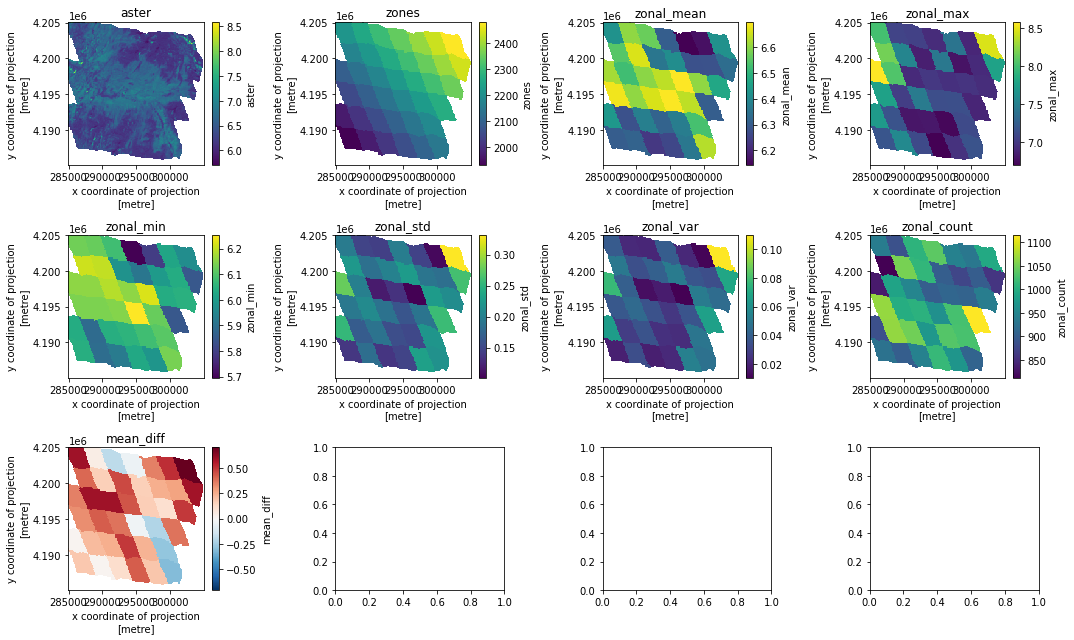

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,9), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds):
    ds[str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))